# This task is to predict company's profitability in the second year using first year's data

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc1").config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven").getOrCreate()
spark

read in data from s3 bucket and drop rows whose label is null

In [3]:
df = spark.read.parquet("s3://502-project-1/data")
df = df.na.drop(subset=['profit'])

fill null with 0

In [4]:
df = df.na.fill(0)

create label column, which is determined by profit
if a company's profit is larger than zero, we label it as 1 (profit-making company)
otherwise, it is zero.

In [5]:
df.createOrReplaceTempView("dfTable")
df = spark.sql("select *, CASE \
                   when profit >= 0 then 1 \
                   when profit < 0 then 0 \
                   end as label from dfTable")

identify columns and numeric columns

In [6]:
cols = ['cik', 'company_name', 'assigned_sic', 'accession_number_int', 'filing_date', 
        'CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
        'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
        'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
        'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 'LaborAndRelatedExpense', 
        'NetCashProvidedByUsedInFinancingActivities', 
        'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInInvestingActivities', 
        'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInOperatingActivities', 
        'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 'NetIncomeLoss', 'OperatingExpenses', 
        'PaymentsForRepurchaseOfCommonStock', 'PaymentsOfDividends', 
        'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 
        'PaymentsToAcquireBusinessesNetOfCashAcquired', 'PaymentsToAcquirePropertyPlantAndEquipment', 
        'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 'Revenues', 'SellingAndMarketingExpense', 
        'ShareBasedCompensation', 'year', 'profit_year', 'profit', 'label']
numericCols = ['CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses','PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']

create features columns using vectorassembler, pipeline

In [7]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=numericCols, outputCol="features", handleInvalid="keep")

In [8]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler])
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- cik: integer (nullable = true)
 |-- company_name: string (nullable = true)
 |-- assigned_sic: integer (nullable = true)
 |-- accession_number_int: long (nullable = true)
 |-- filing_date: date (nullable = true)
 |-- CostOfGoodsAndServicesSold: double (nullable = false)
 |-- CostOfGoodsSold: double (nullable = false)
 |-- CostOfServices: double (nullable = false)
 |-- EarningsPerShareBasic: double (nullable = false)
 |-- EarningsPerShareDiluted: double (nullable = false)
 |-- GainLossOnDispositionOfAssets: double (nullable = false)
 |-- GeneralAndAdministrativeExpense: double (nullable = false)
 |-- IncomeTaxesPaid: double (nullable = false)
 |-- IncreaseDecreaseInAccountsPayable: double (nullable = false)
 |-- IncreaseDecreaseInAccountsReceivable: double (nullable = false)
 |-- IncreaseDecreaseInAccruedLiabilities: double (nullable = false)
 |-- IncreaseDecreaseInInventories: double (nullable = false)
 |-- LaborAndRelatedExpense: double

have a look at df

In [9]:
df.show(5,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----------------------------------+------------+--------------------+-----------+--------------------------+---------------+--------------+---------------------+-----------------------+-----------------------------+-------------------------------+---------------+---------------------------------+------------------------------------+------------------------------------+-----------------------------+----------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+------------

In [10]:
train, test = df.randomSplit([0.85, 0.15], seed=1)

## Logistic Regression

In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

trained coefficients overtime

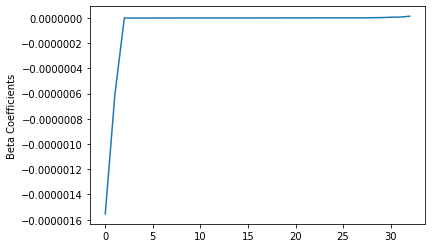

In [12]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

using model to predict test set

In [13]:
predictions = lrModel.transform(test)

AUC

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.901940172428398


F1 and Confusion Matrix

In [15]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred, labels=[0, 1])

              precision    recall  f1-score   support

           0       0.66      0.93      0.77      1174
           1       0.92      0.60      0.73      1448

    accuracy                           0.75      2622
   macro avg       0.79      0.77      0.75      2622
weighted avg       0.80      0.75      0.75      2622



array([[1094,   80],
       [ 572,  876]])

## LightGBM

import and build lightGBM classifier

In [16]:
import mmlspark
from mmlspark.lightgbm import LightGBMClassifier
lgbClassifier = LightGBMClassifier(learningRate=0.3,
                           numIterations=100,
                           numLeaves=31,
                           featuresCol = 'features',
                            labelCol = 'label')

In [17]:
lgbClassifierModel = lgbClassifier.fit(train)

In [18]:
test_class = lgbClassifierModel.transform(test)

In [20]:
eval = BinaryClassificationEvaluator()
print('Test Area Under ROC', eval.evaluate(test_class))

Test Area Under ROC 0.9448775612487882


In [21]:
y_true = test_class.select(['label']).collect()
y_pred = test_class.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred, labels=[0, 1])

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1174
           1       0.90      0.90      0.90      1448

    accuracy                           0.89      2622
   macro avg       0.89      0.89      0.89      2622
weighted avg       0.89      0.89      0.89      2622



array([[1027,  147],
       [ 147, 1301]])

#### We can see that lightGBM classifier outperforms Logistic Regression Classifier!

### regression using LightGBMRegressor
Now we try to further predict value of profit for each company in each fiscal year

In [22]:
from mmlspark.lightgbm import LightGBMRegressor

lgb = LightGBMRegressor(alpha=0.3, learningRate=0.3, numIterations=100, numLeaves=31, featuresCol='features',labelCol='profit')
lgbModel = lgb.fit(train)

In [23]:
test_model = lgbModel.transform(test)

collect true values and predicted values together with corresponding company names

In [24]:
test_true = test_model.select(['profit']).collect()
test_predict = test_model.select(['prediction']).collect()
test_company = test_model.select(['company_name']).collect()

In [25]:
test_true_array = [int(row.profit) for row in test_true]
test_predict_array = [int(row.prediction) for row in test_predict]
test_company_array = [str(row.company_name) for row in test_company]

get feature importance of each column

In [26]:
print(lgbModel.getFeatureImportances())

[17.0, 42.0, 10.0, 226.0, 139.0, 24.0, 52.0, 112.0, 127.0, 81.0, 20.0, 96.0, 31.0, 99.0, 47.0, 134.0, 66.0, 159.0, 80.0, 179.0, 99.0, 165.0, 120.0, 39.0, 184.0, 7.0, 81.0, 110.0, 61.0, 52.0, 181.0, 28.0, 132.0]


showing statistical evaluation of the result, R square is 0.88, which is high

In [27]:
from mmlspark.train import ComputeModelStatistics
metrics = ComputeModelStatistics(evaluationMetric='regression',
                                 labelCol='profit',
                                 scoresCol='prediction') \
            .transform(test_model)
metrics.toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
0,7.106836e+18,2.665865e+09,0.880834,3.391541e+08
